In [1]:
######### Create Stable Diffusion endpoint from custom pix2pix model
# look for detailed instruction here:
# based on this example:
# https://huggingface.co/timbrooks/instruct-pix2pix
#
# Step 1 - create environment for custom model compilation
# Step 2 - create endpoint files
# Step 3 - pack the model and upload to S3
# Step 4 - Create sagemaker model and run inference endpoint
# Step 5 - Test image generation
# Step 6 - clean up Sagemaker endpoints to avoid unexpected charges
#
# Endpoint parameters:
# Input:
#    data structure with:
#      prompt - image changing prompt
#      image_url - URL to image
# Output:
#    generated image
#

In [2]:
# Previous session cleean up
#!rm -rf ./efs

In [3]:
# Step 1 - create environment for custom model compilation

import os
local_package_dir = "./efs/pix2pix_model"  # Directory where local files created
local_model_upload = os.path.join (local_package_dir, "model") # directory where uploaded file structure created
# please create private S3 bucket for compiling model and put it's name here
s3_path_to_models = "s3://miro-integration-ml-model-store"
# create and archive model file
my_model_name = "pix2pix-model-0001.tar.gz"
endpoint_name = "huggingface-example-model-pix2pix-demo-on-miro-1"

# create dirs
!mkdir ./efs
!mkdir $local_package_dir
!mkdir $local_model_upload
!mkdir $local_model_upload/code/

In [6]:
# Step 2 - create endpoint files
# requirements.txt - custom requirements.txt
# inference.py - custom inference

In [4]:
%%writefile $local_model_upload/code/requirements.txt
pillow
diffusers==0.12.1
transformers==4.26.1
accelerate==0.16.0
safetensors==0.2.8
scipy==1.7.3
--extra-index-url https://download.pytorch.org/whl/cu113
torch==1.11.0+cu113
--extra-index-url https://download.pytorch.org/whl/cu113
torchaudio==0.11.0+cu113
--extra-index-url https://download.pytorch.org/whl/cu113
torchvision==0.12.0+cu113


Writing ./efs/pix2pix_model/model/code/requirements.txt


In [5]:
%%writefile $local_model_upload/code/inference.py

import os, json, random
import pkg_resources
from PIL import Image, ImageOps
from io import BytesIO
import base64, requests
import torch


# Initializations section
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler


# Helpers: All helpers going here

# Model
# model_fn(model_dir) overrides the default method for loading a model. 
# The return value model will be used in thepredict_fn for predictions.
#     model_dir is the the path to your unzipped model.tar.gz
def model_fn(model_dir):
    # Log start dir
    # Load and return model from dir
    # 
    print ("----- Custom pix2pix inference on line: model load. Let's look around first.", )
    # Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
    model_id = "timbrooks/instruct-pix2pix"
    pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
    pipe.to("cuda")
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

    # You can uncomment this to look installed python packages
    #installed_packages = pkg_resources.working_set
    #installed_packages_list = sorted(["%s==%s" % (i.key, i.version)
    #   for i in installed_packages])
    #print ("Checking installed packages... \nPackages list: ", installed_packages_list)
    
    
    print ("----- Custom model found in my model directory: ", model_dir)
    
    print ("----- Custom model loaded, see you on inference side ----")
    return pipe

# Data-pre processing
# The return value data will be used in predict_fn for predictions. The inputs are:
#    input_data is the raw body of your request.
#    content_type is the content type from the request header.
#
# def input_fn(input_data, content_type):
    
# Image download helper
def download_image(url):
    image = Image.open(requests.get(url, stream=True).raw)
    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image


# Predictor
# predict_fn(processed_data, model) overrides the default method for predictions. 
# The return value predictions will be used in output_fn.
#
#    model returned value from model_fn methond
#    processed_data returned value from input_fn method
#

def predict_fn(data, model): # predict_fn(processed_data, model) # if you have several assets
    # destruct model and tokenizer
    # 
    
    print ("----- Custom inference online: predictor")
    print ("Request: ", data)
    prompt = data["prompt"]
    img_url = data["image_url"]
    
    image = download_image(img_url)
    image = model(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images[0]
    bytes_io = BytesIO()
    image.save(bytes_io, "JPEG")

        
    result_string = base64.encodebytes(bytes_io.getvalue()).decode("utf-8")
    
    return result_string

# Data post-processing
# The return value result will be the response to your request (e.g.JSON). The inputs are:
#
#    predictions is the result from predict_fn.
#    accept is the return accept type from the HTTP Request, e.g. application/json.
#
#

Writing ./efs/pix2pix_model/model/code/inference.py


In [6]:
%%time
# Step 3 - pack the model and upload to S3
# Archive model files & prepare to upload
!tar -cvzf $local_package_dir/$my_model_name --exclude=".ipynb_*" -C $local_model_upload .

# Upload our model to S3 bucket
import os

full_model_path = os.path.join(s3_path_to_models, my_model_name)
!aws s3 cp $local_package_dir/$my_model_name $full_model_path

./
./code/
./code/requirements.txt
./code/inference.py
upload: efs/pix2pix_model/pix2pix-model-0001.tar.gz to s3://miro-integration-ml-model-store/pix2pix-model-0001.tar.gz
CPU times: user 20.6 ms, sys: 7.84 ms, total: 28.5 ms
Wall time: 1.2 s


In [1]:
# From here we create SageMaker model and inference endpoint
# 
#

In [7]:
%%time
# Step 4 - Create sagemaker model and run inference endpoint
import sagemaker, boto3, os
from sagemaker.huggingface.model import HuggingFaceModel

full_model_path = os.path.join(s3_path_to_models, my_model_name)

# prepare model execution role
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

# create model
# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=full_model_path,       # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.12",  # transformers version used
   pytorch_version="1.9",        # pytorch version used
   py_version='py38',            # python version used
   name=endpoint_name
)

print ("Model created: ", huggingface_model)

# create inference endpoint
# deploy the endpoint endpoint
# Inference types: https://aws.amazon.com/sagemaker/pricing/
instance_type = "ml.g4dn.2xlarge"

predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    endpoint_name=endpoint_name
    )

print("Endpoint name: ", endpoint_name)

Model created:  <sagemaker.huggingface.model.HuggingFaceModel object at 0x7fb33d02b460>
-----------!Endpoint name:  huggingface-example-model-pix2pix-demo-on-miro-1
CPU times: user 1.34 s, sys: 160 ms, total: 1.5 s
Wall time: 6min 4s


In [102]:
%%time
# Step 5 - Test image generation

data = {
    "prompt" : "turn him into cyborg",
    "image_url" : "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
}

result = predictor.predict(data)

CPU times: user 4.59 ms, sys: 0 ns, total: 4.59 ms
Wall time: 3.07 s


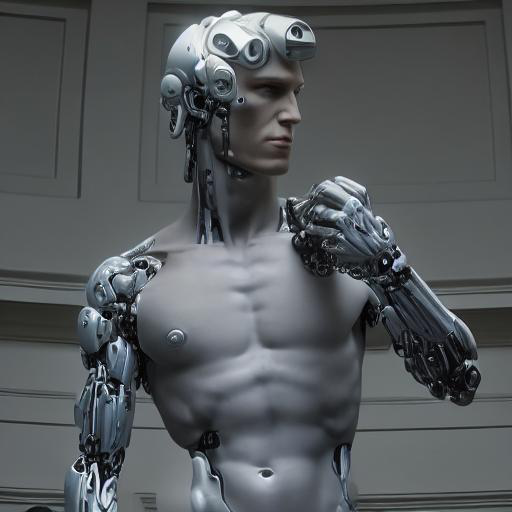

In [103]:
# Create image from result
from io import BytesIO
import base64
from PIL import Image

# What to do with string to make it bytes again
new_byte_io = BytesIO(base64.decodebytes(result.encode("utf-8")))

new_image = Image.open(new_byte_io)
new_image.show()

In [11]:
%%time
import json, base64
from io import BytesIO
from PIL import Image

runtime = boto3.client('runtime.sagemaker')
parameters = b'{    "action": "modify", "prompt": "turn him into cyborg", "image_url": "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"}'
#
print ("Call endpoint: ", endpoint_name)
print ("With parameters: ", parameters)
response = runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType='application/json',
                                   Body=parameters)
print ("Received reply from endpoint, len: ", len(response))
# What to do with string to make it bytes again
response_image = response["Body"]
stream = response_image.read()
data = json.loads(stream)
# base64.encodebytes(byte_io.getvalue()).decode("utf-8")
new_byte_io = BytesIO(base64.decodebytes(data.encode("utf-8")))
new_image = Image.open(new_byte_io)

Call endpoint:  huggingface-example-model-pix2pix-demo-on-miro-1
With parameters:  b'{    "action": "modify", "prompt": "turn him into cyborg", "image_url": "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"}'
Received reply from endpoint, len:  4
CPU times: user 58.8 ms, sys: 7.57 ms, total: 66.4 ms
Wall time: 3.21 s


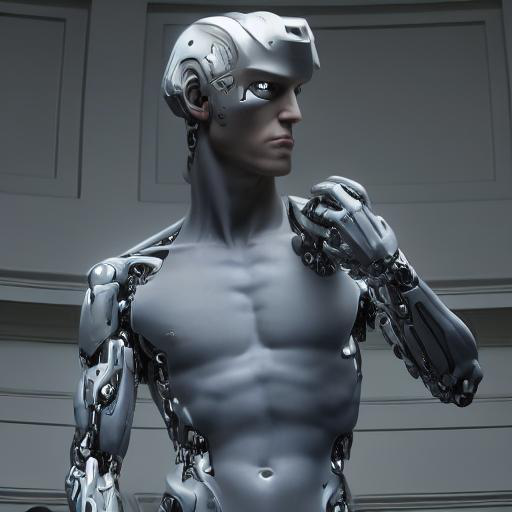

In [12]:
new_image

In [ ]:
# Step 6 - clean up Sagemaker endpoints to avoid unexpected charges
#### After successful demo, please don't forget to clean up the endpoints to avoid unexpected charges ###############################
import sagemaker
predictor = sagemaker.predictor.Predictor(endpoint_name)
predictor.delete_model()
predictor.delete_endpoint()
